# Train HeterSUMGraph NER POL

In [1]:
import pandas as pd
import argparse
from time import time
import torch
import numpy as np
import random
from sklearn.utils import shuffle
import json
import os
import networkx as nx
import torch_geometric
from statistics import mean
import matplotlib.pyplot as plt

from tqdm import tqdm

from rouge_score import rouge_scorer

from utils_pol.create_graph_dataset import create_graph_dataset
from utils_pol.EmbMgr import EmbMgr
from utils_pol.DataLoader import DataLoader
from utils_pol.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils_pol.split_all_docs import split_all_docs
from utils_pol.threshold_probs import threshold_probs_by_nb, threshold_probs_by_prop
from utils_pol.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn
from torch import nn

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

## (Hyper-)parameters

In [3]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=2)
parser.add_argument('-epochs',type=int,default=10)
parser.add_argument('-dataset',type=str,default="data/wiki_geo_ratio_sc_0.5")
parser.add_argument('-dataset_tfidf',type=str,default="./data/wiki_geo_ratio_sc_0.5_dataset_tfidf.json")
parser.add_argument('-sent_tfidf',type=str,default="data/wiki_geo_ratio_sc_0.5_sent_tfidf.json")
parser.add_argument('-doc_column_name',type=str,default="flat_contents")
parser.add_argument('-labels_sum_column_name',type=str,default="labels_sentences")
parser.add_argument('-labels_ner_column_name',type=str,default="labels_entities")
parser.add_argument("-word_emb",type=str,default="./data/cc.fr.300.vec")

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [4]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "cc.fr.300.vec"

# hyper-parameters
vocab_size = 50000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 5e-4
early_stopping = 3
word_blacklist_proportion = 0.1
model_name = "04-train_HeterSUMGraphNERPOL_GAT"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}__early_stopping__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num, early_stopping)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_number_of_sentences_per_document = 3
loss_sum_coef = 0.5
loss_ner_coef = 0.5

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 2


## PyTorch initialisation

In [5]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
  # Display the number of available GPUs
  print(f"Number of available GPUs: {torch.cuda.device_count()}")
  # Display the name of each GPU
  for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
elif torch.backends.mps.is_available():
  print("MPS available.")
else:
  print("No GPU available.")

Number of available GPUs: 6
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080 Ti
GPU 3: NVIDIA GeForce GTX 1080
GPU 4: NVIDIA GeForce GTX 1080
GPU 5: NVIDIA GeForce GTX 1080


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
elif torch.backends.mps.is_available():
  dev = torch.device("mps")
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Load data

In [8]:
embmgr = EmbMgr(args.word_emb, vocab_size=vocab_size, header=True)

In [9]:
tfidfs_sent = pd.read_json(args.sent_tfidf)

In [10]:
tfidfs_dataset = json.load(open(args.dataset_tfidf))
tfidfs_dataset_sorted = sorted(tfidfs_dataset, key=tfidfs_dataset.get)
word_blacklist = set(tfidfs_dataset_sorted[:int(word_blacklist_proportion*len(tfidfs_dataset_sorted))])

In [11]:
df_test = pd.read_json(args.dataset + "/test.json")
df_val = pd.read_json(args.dataset + "/val.json")
df_train = pd.read_json(args.dataset + "/train.json")

In [12]:
train_dataset = create_graph_dataset(df=df_train, tfidfs_sent=tfidfs_sent, embmgr=embmgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name=args.doc_column_name, labels_sum_column_name=args.labels_sum_column_name, labels_ner_column_name=args.labels_ner_column_name, is_sep_n=False, remove_stop_word = True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)
val_dataset = create_graph_dataset(df=df_val, tfidfs_sent=tfidfs_sent, embmgr=embmgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name=args.doc_column_name, labels_sum_column_name=args.labels_sum_column_name, labels_ner_column_name=args.labels_ner_column_name, is_sep_n=False, remove_stop_word = True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)
test_dataset = create_graph_dataset(df=df_test, tfidfs_sent=tfidfs_sent, embmgr=embmgr, word_blacklist = word_blacklist, remove_unkn_words=False, doc_column_name=args.doc_column_name, labels_sum_column_name=args.labels_sum_column_name, labels_ner_column_name=args.labels_ner_column_name, is_sep_n=False, remove_stop_word = True, stemming=False, trunc_sent=-1, padding_sent=-1, trunc_doc=100)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, ner=True)
val_loader =  DataLoader(val_dataset, batch_size=1, shuffle=False, ner=True)
test_loader =  DataLoader(test_dataset, batch_size=1, shuffle=False, ner=True)

## Graph stats

In [14]:
# Average number of distinct word per doc
print("Average number of distinct word per doc:", mean([len(t["docs"].x[0]) for t in train_dataset]))

Average number of distinct word per doc: 309.29


In [15]:
def sents_len(doc):
  return [torch.sum(torch.sign(s),dim=0).item() for s in doc]

# Average sentence length
lens = []
for t in train_dataset:
  lens = lens + sents_len(t["docs"].x[1])

print("Average sentence len:", mean(lens))

Average sentence len: 15.202316412025628


In [16]:
# Average density
def density(g):
  nb_edges = g.num_edges / 2
  nb_nodes = g.num_nodes
  nb_poss_edges = nb_nodes * (nb_nodes - 1) / 2
  return nb_edges / nb_poss_edges

print("Average density:", mean([density(t["docs"]) for t in train_dataset]))

Average density: 0.016426792711350446


/home/raoufdine/anaconda3/lib/python3.9/site-packages/torch_geometric/data/storage.py:303: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'edge_attr', 'x', 'undirected'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [17]:
# Average clustering
def average_clustering(g):
  G = nx.Graph()
  edge_list = g.edge_index.t().tolist()
  G.add_edges_from(edge_list)
  return nx.average_clustering(G)

print("Average clustering:", mean([average_clustering(t["docs"]) for t in train_dataset]))

Average clustering: 0.0


## Model

In [18]:
import torch.nn as nn
from torch_geometric.nn import GATConv

In [19]:
# Position Feed Forward
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_in, d_out, d_h, dropout=0.1) -> None:
    super(PositionwiseFeedForward, self).__init__()
    self.fc1 = nn.Linear(in_features=d_in, out_features=d_h)
    self.fc2 = nn.Linear(in_features=d_h, out_features=d_out)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.dropout(x)
    return self.fc2(x)

In [20]:
class HeterSUMGraph(torch.nn.Module):
  def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 300, num_iter=3):
    super(HeterSUMGraph, self).__init__()
    self.device = device
    self.num_iter = num_iter

    self.word_emb = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)

    # Load word embedding if specified
    if word_embed is not None:
      self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

    self.word_emb.weight.requires_grad = False

    # edge_attr embed
    self.edge_attr_embed = nn.Embedding(101, 50)

    # sent CNN
    dim_out_cnn = 64
    self.convs = nn.Sequential(
                            nn.Conv1d(in_channels=300,out_channels=100,kernel_size=3,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=100,kernel_size=4,padding='same'),
                            nn.BatchNorm1d(num_features=100),
                            nn.ReLU(inplace=True),
                            nn.Conv1d(in_channels=100,out_channels=dim_out_cnn,kernel_size=5,padding='same'),
                            nn.BatchNorm1d(num_features=dim_out_cnn),
                            nn.ReLU(inplace=True))

    # sent LSTM
    dim_out_lstm = 32
    self.sent_LSTM = nn.LSTM(input_size=300, hidden_size=dim_out_lstm, batch_first=True, bidirectional=True)

    # sent to word GAT
    self.s2wGAT = GATConv(in_channels=[128, 300], out_channels=300, heads=8, edge_dim=50, fill_value=0)

    # word to sen GAT
    self.w2sGAT = GATConv(in_channels=[300, 128], out_channels=128, heads=8, edge_dim=50, fill_value=0)

    # ffn sent to word
    self.ffns2w = PositionwiseFeedForward(d_in=8*300, d_out=300, d_h=512)

    # ffn word to sent
    self.ffnw2s = PositionwiseFeedForward(d_in=8*128, d_out=128, d_h=512)

    # predict summary
    self.w_sum = nn.Linear(128, 1)
    
    # NER
    self.w_ner = nn.Linear(300 + 50, 1)

  def max_pool1d(self, x, seq_lens):
    out = []
    for index,t in enumerate(x):
      if seq_lens[index] == 0:
        t = t[:1]
      else:
        t = t[:seq_lens[index],:]
      t = torch.t(t).unsqueeze(0)
      out.append(torch.avg_pool1d(t, t.size(2)))

    out = torch.cat(out).squeeze(2)
    return out

  def forward(self, data):# In the real implémentation remove nb_sent
    # edge attr embeddings
    edge_attr = torch.floor(data.edge_attr * 100).int()
    edge_attr = self.edge_attr_embed(edge_attr)

    # features
    Xw = data.x[0]
    Xs = data.x[1]
    sent_lens = torch.sum(torch.sign(Xs),dim=1).data
    
    # embeddings
    Xw = self.word_emb(Xw)
    Xs = self.word_emb(Xs)

    # CNN
    XsCNN = self.convs(Xs.permute(0,2,1))
    XsCNN = torch.max_pool1d(XsCNN, XsCNN.size(2)).squeeze(2)

    # LSTM
    # TO DO: ask 
    XsLSTM, _ = self.sent_LSTM(Xs)
    XsLSTM = self.max_pool1d(XsLSTM, sent_lens)
    Xs = torch.cat((XsCNN, XsLSTM), dim=1)

    Hw = Xw
    Hs = Xs

    edge_index_w_i = data.edge_index[1][data.edge_index[1] < len(data.x[0])]
    edge_index_s_j = data.edge_index[0][data.edge_index[1] < len(data.x[0])] - Hw.shape[0]
    edge_attr_w = edge_attr[data.edge_index[1] < len(data.x[0])]
    edge_index_w = torch.stack([edge_index_s_j, edge_index_w_i])

    edge_index_s_i = data.edge_index[1][data.edge_index[1] >= len(data.x[0])] - Hw.shape[0]
    edge_index_w_j = data.edge_index[0][data.edge_index[1] >= len(data.x[0])]
    edge_attr_s = edge_attr[data.edge_index[1] >= len(data.x[0])]
    edge_index_s = torch.stack([edge_index_w_j, edge_index_s_i])

    Hw = torch.layer_norm(Hw, Hw.size()[1:])
    Hs = torch.layer_norm(Hs, Hs.size()[1:])

    for i in range(self.num_iter):
      if i != 0: # H^1w = H^0w = Xw
        Hw = self.s2wGAT(x=[Hs, Hw], edge_index=edge_index_w, edge_attr=edge_attr_w) + torch.cat([Hw] * 8, dim=1)
        Hw = self.ffns2w(Hw)
        Hw = torch.layer_norm(Hw, Hw.size()[1:])

      Hs = self.w2sGAT(x=[Hw, Hs], edge_index=edge_index_s, edge_attr=edge_attr_s) + torch.cat([Hs] * 8, dim=1)
      Hs = self.ffnw2s(Hs)
      Hs = torch.layer_norm(Hs, Hs.size()[1:])

    # get indexes and attr list
    edge_index_w = edge_index_w_i
    edge_index_s = edge_index_s_j
    edge_attr = edge_attr_w

    # Duplicate Hw as many times as there is a sentence that contains it
    v, c = torch.unique(edge_index_w, return_counts=True, sorted=True)

    tmp_c = torch.zeros(Hw.shape[0], dtype=torch.long).to(Hw.device)
    tmp_c[v] = c
    c = tmp_c

    Hw = Hw.repeat_interleave(c, 0)

    # Get attr list
    eiw_sorted = torch.argsort(edge_index_w)
    attrs = edge_attr[eiw_sorted]

    # Concat
    Hw = torch.cat((Hw, attrs), dim=1)

    o_sum = self.w_sum(Hs)
    o_sum = torch.sigmoid(o_sum).squeeze(-1)

    o_ner = self.w_ner(Hw)
    o_ner = torch.sigmoid(o_ner).squeeze(-1)

    return o_sum, o_ner

  def save(self, fname):
    torch.save(self.state_dict(), fname)

  def load(self, fname):
    self.load_state_dict(torch.load(fname))

In [21]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings(), dim_word_embed=300)
model = model.to(device=device)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
criterion = nn.BCELoss()

## Train

In [24]:
if not os.path.exists(checkpoints_folder):
  os.makedirs(checkpoints_folder)

In [25]:
df_val["doc_splitted"] = split_all_docs(df_val[args.doc_column_name])
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [26]:
import math

arr_train_loss = []
arr_train_loss_sum = []
arr_train_loss_ner = []
arr_train_acc_sum = []
arr_train_acc_ner = []
arr_val_loss = []
arr_val_acc_sum = []
arr_val_acc_ner = []

t1 = time()

for epoch in range(1, epochs+1):
  # Train
  model.train()
  nb_batch_train = 0
  total_train_loss = 0
  total_train_loss_sum = 0
  total_train_loss_ner = 0
  total_train_acc_sum = 0
  total_train_acc_ner = 0
  with tqdm(train_loader, unit="batch", total=len(train_loader)) as tepoch:
    for batch in tepoch:
      tepoch.set_description(f"Epoch {epoch}")
      #if dev != "cpu":
      #  torch.cuda.empty_cache()
      doc_lens = batch["doc_lens"]
      data = batch["docs"].to(device)
      targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
      targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)
      
      y_sum_pred, y_ner_pred = model(data)

      loss_sum = criterion(y_sum_pred, targets_sum)
      loss_ner = criterion(y_ner_pred, targets_ner)
      
      loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner
      
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      nb_batch_train += 1
      total_train_loss += loss.item()
      total_train_loss_sum += loss_sum.item()
      total_train_loss_ner += loss_ner.item()

      probs = y_sum_pred.tolist() # compute_probs(y_pred)
      probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

      total_train_acc_sum += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)
      total_train_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

      tepoch.set_postfix(loss=total_train_loss/nb_batch_train, loss_sum=total_train_loss_sum/nb_batch_train, loss_ner=total_train_loss_ner/nb_batch_train, accuracy_sum=total_train_acc_sum/nb_batch_train, accuracy_ner=total_train_acc_ner/nb_batch_train)

  # Save model
  model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

  # Eval
  model.eval()
  nb_batch_val = 0
  total_val_loss = 0
  total_val_loss_sum = 0
  total_val_loss_ner = 0
  total_val_acc_sum = 0
  total_val_acc_ner = 0
  total_r1 = 0
  total_r2 = 0
  total_rl = 0

  del loss
  del loss_sum
  del loss_ner
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  for i, batch in enumerate(val_loader):
    #if dev != "cpu":
    #  torch.cuda.empty_cache()
    doc_lens = batch["doc_lens"]
    data = batch["docs"].to(device)
    targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
    targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)

    y_sum_pred, y_ner_pred = model(data)

    loss_sum = criterion(y_sum_pred, targets_sum)
    loss_ner = criterion(y_ner_pred, targets_ner)
    
    loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

    nb_batch_val += 1
    total_val_loss += loss.item()
    total_val_loss_sum += loss_sum.item()
    total_val_loss_ner += loss_ner.item()

    doc = val_set["doc_splitted"].iloc[i]
    summaries = val_set["summaries"].iloc[i]

    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for j in range(min(len(doc), y_sum_pred.shape[0])):
      txt = txt + ". " + doc[indices[j]]
      y_pred_thresh.append(indices[j])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for j in y_pred_thresh:
      txt = txt + ". " + doc[j]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    scores = scorer.score(summaries, txt)
    total_r1 += scores["rouge1"].recall
    total_r2 += scores["rouge2"].recall
    total_rl += scores["rougeL"].recall

    probs = y_sum_pred.tolist() # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    total_val_acc_sum += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    total_val_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

  print("Epoch {} : val loss = {:.3f}, val loss summary = {:.3f}, val loss ner = {:.3f}, val accuracy summary = {:.3f}, val accuracy ner = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_loss_sum / nb_batch_val, total_val_loss_ner / nb_batch_val, total_val_acc_sum / nb_batch_val, total_val_acc_ner / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

  if len(arr_val_loss) >= early_stopping+1:
    if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
      break

  del loss
  del loss_sum
  del loss_ner
  del y_sum_pred
  del y_ner_pred

  if dev != "cpu":
    torch.cuda.empty_cache()

  arr_train_loss.append(total_train_loss / nb_batch_train)
  
  arr_train_acc_sum.append(total_train_acc_sum / nb_batch_train)
  arr_train_acc_ner.append(total_train_acc_ner / nb_batch_train)

  arr_val_loss.append(total_val_loss / nb_batch_val)
  arr_val_acc_sum.append(total_val_acc_sum / nb_batch_val)
  arr_val_acc_ner.append(total_val_acc_ner / nb_batch_val)

t2 = time()
print("Training duration =", t2-t1)

Epoch 1:   0%|          | 0/50 [00:00<?, ?batch/s]/home/raoufdine/.local/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
Epoch 1: 100%|██████████| 50/50 [00:05<00:00,  9.70batch/s, accuracy_ner=0.878, accuracy_sum=0.701, loss=0.469, loss_ner=0.326, loss_sum=0.612]


Epoch 1 : val loss = 0.480, val loss summary = 0.662, val loss ner = 0.298, val accuracy summary = 0.712, val accuracy ner = 0.892, r1 = 0.323, r2 = 0.108, rL = 0.210


Epoch 2: 100%|██████████| 50/50 [00:04<00:00, 11.50batch/s, accuracy_ner=0.89, accuracy_sum=0.696, loss=0.455, loss_ner=0.288, loss_sum=0.622] 


Epoch 2 : val loss = 0.513, val loss summary = 0.754, val loss ner = 0.272, val accuracy summary = 0.721, val accuracy ner = 0.893, r1 = 0.299, r2 = 0.083, rL = 0.189


Epoch 3: 100%|██████████| 50/50 [00:03<00:00, 13.74batch/s, accuracy_ner=0.9, accuracy_sum=0.731, loss=0.425, loss_ner=0.258, loss_sum=0.592]  


Epoch 3 : val loss = 0.433, val loss summary = 0.628, val loss ner = 0.237, val accuracy summary = 0.716, val accuracy ner = 0.896, r1 = 0.314, r2 = 0.094, rL = 0.199


Epoch 4: 100%|██████████| 50/50 [00:04<00:00, 12.18batch/s, accuracy_ner=0.899, accuracy_sum=0.732, loss=0.413, loss_ner=0.234, loss_sum=0.593]


Epoch 4 : val loss = 0.426, val loss summary = 0.635, val loss ner = 0.217, val accuracy summary = 0.722, val accuracy ner = 0.897, r1 = 0.302, r2 = 0.086, rL = 0.186


Epoch 5: 100%|██████████| 50/50 [00:04<00:00, 12.01batch/s, accuracy_ner=0.904, accuracy_sum=0.734, loss=0.403, loss_ner=0.215, loss_sum=0.591]


Epoch 5 : val loss = 0.412, val loss summary = 0.628, val loss ner = 0.196, val accuracy summary = 0.706, val accuracy ner = 0.902, r1 = 0.296, r2 = 0.086, rL = 0.185


Epoch 6: 100%|██████████| 50/50 [00:04<00:00, 11.91batch/s, accuracy_ner=0.906, accuracy_sum=0.732, loss=0.398, loss_ner=0.215, loss_sum=0.581]


Epoch 6 : val loss = 0.424, val loss summary = 0.643, val loss ner = 0.204, val accuracy summary = 0.721, val accuracy ner = 0.900, r1 = 0.307, r2 = 0.088, rL = 0.193


Epoch 7: 100%|██████████| 50/50 [00:04<00:00, 11.85batch/s, accuracy_ner=0.903, accuracy_sum=0.749, loss=0.393, loss_ner=0.21, loss_sum=0.575] 


Epoch 7 : val loss = 0.396, val loss summary = 0.594, val loss ner = 0.198, val accuracy summary = 0.735, val accuracy ner = 0.907, r1 = 0.315, r2 = 0.096, rL = 0.202


Epoch 8: 100%|██████████| 50/50 [00:04<00:00, 11.98batch/s, accuracy_ner=0.909, accuracy_sum=0.752, loss=0.381, loss_ner=0.203, loss_sum=0.558]


Epoch 8 : val loss = 0.374, val loss summary = 0.547, val loss ner = 0.202, val accuracy summary = 0.753, val accuracy ner = 0.910, r1 = 0.326, r2 = 0.104, rL = 0.212


Epoch 9: 100%|██████████| 50/50 [00:04<00:00, 11.97batch/s, accuracy_ner=0.91, accuracy_sum=0.756, loss=0.378, loss_ner=0.195, loss_sum=0.561] 


Epoch 9 : val loss = 0.361, val loss summary = 0.529, val loss ner = 0.192, val accuracy summary = 0.761, val accuracy ner = 0.911, r1 = 0.331, r2 = 0.109, rL = 0.215


Epoch 10: 100%|██████████| 50/50 [00:04<00:00, 10.58batch/s, accuracy_ner=0.908, accuracy_sum=0.765, loss=0.37, loss_ner=0.196, loss_sum=0.544] 


Epoch 10 : val loss = 0.343, val loss summary = 0.497, val loss ner = 0.189, val accuracy summary = 0.775, val accuracy ner = 0.910, r1 = 0.335, r2 = 0.109, rL = 0.215


Epoch 11: 100%|██████████| 50/50 [00:04<00:00, 10.79batch/s, accuracy_ner=0.912, accuracy_sum=0.775, loss=0.366, loss_ner=0.194, loss_sum=0.537]


Epoch 11 : val loss = 0.338, val loss summary = 0.486, val loss ner = 0.191, val accuracy summary = 0.776, val accuracy ner = 0.912, r1 = 0.344, r2 = 0.120, rL = 0.226


Epoch 12: 100%|██████████| 50/50 [00:04<00:00, 11.75batch/s, accuracy_ner=0.913, accuracy_sum=0.776, loss=0.358, loss_ner=0.192, loss_sum=0.525]


Epoch 12 : val loss = 0.341, val loss summary = 0.483, val loss ner = 0.199, val accuracy summary = 0.775, val accuracy ner = 0.902, r1 = 0.334, r2 = 0.115, rL = 0.218


Epoch 13: 100%|██████████| 50/50 [00:04<00:00, 12.16batch/s, accuracy_ner=0.916, accuracy_sum=0.779, loss=0.349, loss_ner=0.181, loss_sum=0.518]


Epoch 13 : val loss = 0.302, val loss summary = 0.426, val loss ner = 0.179, val accuracy summary = 0.792, val accuracy ner = 0.916, r1 = 0.332, r2 = 0.112, rL = 0.216


Epoch 14: 100%|██████████| 50/50 [00:04<00:00, 11.88batch/s, accuracy_ner=0.911, accuracy_sum=0.768, loss=0.35, loss_ner=0.192, loss_sum=0.508] 


Epoch 14 : val loss = 0.307, val loss summary = 0.418, val loss ner = 0.196, val accuracy summary = 0.793, val accuracy ner = 0.910, r1 = 0.326, r2 = 0.107, rL = 0.210


Epoch 15: 100%|██████████| 50/50 [00:04<00:00, 11.77batch/s, accuracy_ner=0.91, accuracy_sum=0.794, loss=0.333, loss_ner=0.198, loss_sum=0.467] 


Epoch 15 : val loss = 0.307, val loss summary = 0.415, val loss ner = 0.199, val accuracy summary = 0.795, val accuracy ner = 0.907, r1 = 0.337, r2 = 0.115, rL = 0.218


Epoch 16: 100%|██████████| 50/50 [00:04<00:00, 11.79batch/s, accuracy_ner=0.911, accuracy_sum=0.789, loss=0.323, loss_ner=0.202, loss_sum=0.443]


Epoch 16 : val loss = 0.300, val loss summary = 0.396, val loss ner = 0.203, val accuracy summary = 0.806, val accuracy ner = 0.905, r1 = 0.343, r2 = 0.118, rL = 0.223


Epoch 17: 100%|██████████| 50/50 [00:04<00:00, 11.77batch/s, accuracy_ner=0.903, accuracy_sum=0.787, loss=0.305, loss_ner=0.213, loss_sum=0.396]


Epoch 17 : val loss = 0.235, val loss summary = 0.272, val loss ner = 0.197, val accuracy summary = 0.820, val accuracy ner = 0.911, r1 = 0.351, r2 = 0.126, rL = 0.225


Epoch 18: 100%|██████████| 50/50 [00:04<00:00, 12.18batch/s, accuracy_ner=0.906, accuracy_sum=0.788, loss=0.279, loss_ner=0.21, loss_sum=0.348] 


Epoch 18 : val loss = 0.279, val loss summary = 0.350, val loss ner = 0.207, val accuracy summary = 0.818, val accuracy ner = 0.901, r1 = 0.346, r2 = 0.117, rL = 0.220


Epoch 19: 100%|██████████| 50/50 [00:04<00:00, 11.78batch/s, accuracy_ner=0.909, accuracy_sum=0.788, loss=0.261, loss_ner=0.199, loss_sum=0.324]


Epoch 19 : val loss = 0.195, val loss summary = 0.190, val loss ner = 0.200, val accuracy summary = 0.823, val accuracy ner = 0.908, r1 = 0.350, r2 = 0.124, rL = 0.224


Epoch 20: 100%|██████████| 50/50 [00:04<00:00, 11.99batch/s, accuracy_ner=0.911, accuracy_sum=0.778, loss=0.227, loss_ner=0.198, loss_sum=0.256]


Epoch 20 : val loss = 0.176, val loss summary = 0.155, val loss ner = 0.198, val accuracy summary = 0.825, val accuracy ner = 0.905, r1 = 0.353, r2 = 0.125, rL = 0.225


Epoch 21: 100%|██████████| 50/50 [00:04<00:00, 12.02batch/s, accuracy_ner=0.91, accuracy_sum=0.79, loss=0.202, loss_ner=0.197, loss_sum=0.207]  


Epoch 21 : val loss = 0.158, val loss summary = 0.125, val loss ner = 0.192, val accuracy summary = 0.824, val accuracy ner = 0.911, r1 = 0.358, r2 = 0.131, rL = 0.235


Epoch 22: 100%|██████████| 50/50 [00:04<00:00, 11.72batch/s, accuracy_ner=0.916, accuracy_sum=0.791, loss=0.186, loss_ner=0.183, loss_sum=0.189]


Epoch 22 : val loss = 0.146, val loss summary = 0.103, val loss ner = 0.188, val accuracy summary = 0.824, val accuracy ner = 0.913, r1 = 0.341, r2 = 0.122, rL = 0.221


Epoch 23: 100%|██████████| 50/50 [00:04<00:00, 12.05batch/s, accuracy_ner=0.914, accuracy_sum=0.801, loss=0.177, loss_ner=0.191, loss_sum=0.162]


Epoch 23 : val loss = 0.141, val loss summary = 0.095, val loss ner = 0.186, val accuracy summary = 0.826, val accuracy ner = 0.910, r1 = 0.353, r2 = 0.128, rL = 0.232


Epoch 24: 100%|██████████| 50/50 [00:04<00:00, 11.90batch/s, accuracy_ner=0.916, accuracy_sum=0.798, loss=0.164, loss_ner=0.187, loss_sum=0.142]


Epoch 24 : val loss = 0.134, val loss summary = 0.089, val loss ner = 0.179, val accuracy summary = 0.826, val accuracy ner = 0.914, r1 = 0.349, r2 = 0.125, rL = 0.226


Epoch 25: 100%|██████████| 50/50 [00:04<00:00, 10.59batch/s, accuracy_ner=0.912, accuracy_sum=0.786, loss=0.152, loss_ner=0.184, loss_sum=0.12] 


Epoch 25 : val loss = 0.119, val loss summary = 0.063, val loss ner = 0.176, val accuracy summary = 0.826, val accuracy ner = 0.918, r1 = 0.350, r2 = 0.127, rL = 0.227


Epoch 26: 100%|██████████| 50/50 [00:04<00:00, 11.97batch/s, accuracy_ner=0.908, accuracy_sum=0.8, loss=0.15, loss_ner=0.192, loss_sum=0.109]    


Epoch 26 : val loss = 0.118, val loss summary = 0.061, val loss ner = 0.174, val accuracy summary = 0.826, val accuracy ner = 0.916, r1 = 0.345, r2 = 0.120, rL = 0.223


Epoch 27: 100%|██████████| 50/50 [00:04<00:00, 11.93batch/s, accuracy_ner=0.913, accuracy_sum=0.794, loss=0.146, loss_ner=0.178, loss_sum=0.114] 


Epoch 27 : val loss = 0.118, val loss summary = 0.062, val loss ner = 0.174, val accuracy summary = 0.826, val accuracy ner = 0.918, r1 = 0.346, r2 = 0.124, rL = 0.224


Epoch 28: 100%|██████████| 50/50 [00:04<00:00, 11.87batch/s, accuracy_ner=0.921, accuracy_sum=0.808, loss=0.135, loss_ner=0.171, loss_sum=0.0979]


Epoch 28 : val loss = 0.113, val loss summary = 0.058, val loss ner = 0.168, val accuracy summary = 0.826, val accuracy ner = 0.920, r1 = 0.347, r2 = 0.125, rL = 0.227


Epoch 29: 100%|██████████| 50/50 [00:04<00:00, 10.84batch/s, accuracy_ner=0.92, accuracy_sum=0.799, loss=0.126, loss_ner=0.169, loss_sum=0.0832] 


Epoch 29 : val loss = 0.113, val loss summary = 0.062, val loss ner = 0.164, val accuracy summary = 0.825, val accuracy ner = 0.920, r1 = 0.353, r2 = 0.131, rL = 0.227


Epoch 30: 100%|██████████| 50/50 [00:04<00:00, 11.88batch/s, accuracy_ner=0.918, accuracy_sum=0.808, loss=0.124, loss_ner=0.17, loss_sum=0.0776] 


Epoch 30 : val loss = 0.108, val loss summary = 0.055, val loss ner = 0.162, val accuracy summary = 0.826, val accuracy ner = 0.924, r1 = 0.358, r2 = 0.133, rL = 0.233


Epoch 31: 100%|██████████| 50/50 [00:04<00:00, 12.06batch/s, accuracy_ner=0.922, accuracy_sum=0.808, loss=0.124, loss_ner=0.166, loss_sum=0.0826] 


Epoch 31 : val loss = 0.102, val loss summary = 0.044, val loss ner = 0.160, val accuracy summary = 0.826, val accuracy ner = 0.924, r1 = 0.343, r2 = 0.122, rL = 0.224


Epoch 32: 100%|██████████| 50/50 [00:03<00:00, 13.35batch/s, accuracy_ner=0.923, accuracy_sum=0.811, loss=0.117, loss_ner=0.163, loss_sum=0.0719]


Epoch 32 : val loss = 0.101, val loss summary = 0.044, val loss ner = 0.158, val accuracy summary = 0.824, val accuracy ner = 0.908, r1 = 0.353, r2 = 0.131, rL = 0.235


Epoch 33: 100%|██████████| 50/50 [00:04<00:00, 12.36batch/s, accuracy_ner=0.921, accuracy_sum=0.802, loss=0.111, loss_ner=0.163, loss_sum=0.0595]


Epoch 33 : val loss = 0.094, val loss summary = 0.034, val loss ner = 0.153, val accuracy summary = 0.826, val accuracy ner = 0.926, r1 = 0.354, r2 = 0.132, rL = 0.230


Epoch 34: 100%|██████████| 50/50 [00:04<00:00, 12.39batch/s, accuracy_ner=0.92, accuracy_sum=0.803, loss=0.117, loss_ner=0.164, loss_sum=0.0696] 


Epoch 34 : val loss = 0.096, val loss summary = 0.039, val loss ner = 0.152, val accuracy summary = 0.826, val accuracy ner = 0.926, r1 = 0.349, r2 = 0.125, rL = 0.228


Epoch 35: 100%|██████████| 50/50 [00:04<00:00, 11.91batch/s, accuracy_ner=0.921, accuracy_sum=0.807, loss=0.109, loss_ner=0.158, loss_sum=0.0603]


Epoch 35 : val loss = 0.093, val loss summary = 0.034, val loss ner = 0.151, val accuracy summary = 0.826, val accuracy ner = 0.928, r1 = 0.344, r2 = 0.126, rL = 0.223


Epoch 36: 100%|██████████| 50/50 [00:04<00:00, 12.16batch/s, accuracy_ner=0.923, accuracy_sum=0.804, loss=0.104, loss_ner=0.156, loss_sum=0.0526] 


Epoch 36 : val loss = 0.091, val loss summary = 0.035, val loss ner = 0.147, val accuracy summary = 0.826, val accuracy ner = 0.923, r1 = 0.355, r2 = 0.132, rL = 0.233


Epoch 37: 100%|██████████| 50/50 [00:04<00:00, 10.84batch/s, accuracy_ner=0.927, accuracy_sum=0.81, loss=0.108, loss_ner=0.153, loss_sum=0.0635]  


Epoch 37 : val loss = 0.089, val loss summary = 0.034, val loss ner = 0.144, val accuracy summary = 0.826, val accuracy ner = 0.932, r1 = 0.347, r2 = 0.128, rL = 0.226


Epoch 38: 100%|██████████| 50/50 [00:04<00:00, 12.32batch/s, accuracy_ner=0.931, accuracy_sum=0.801, loss=0.101, loss_ner=0.148, loss_sum=0.0537] 


Epoch 38 : val loss = 0.086, val loss summary = 0.030, val loss ner = 0.142, val accuracy summary = 0.826, val accuracy ner = 0.932, r1 = 0.356, r2 = 0.127, rL = 0.231


Epoch 39: 100%|██████████| 50/50 [00:04<00:00, 12.18batch/s, accuracy_ner=0.928, accuracy_sum=0.794, loss=0.1, loss_ner=0.151, loss_sum=0.049]    


Epoch 39 : val loss = 0.084, val loss summary = 0.030, val loss ner = 0.139, val accuracy summary = 0.826, val accuracy ner = 0.932, r1 = 0.351, r2 = 0.127, rL = 0.229


Epoch 40: 100%|██████████| 50/50 [00:04<00:00, 11.70batch/s, accuracy_ner=0.929, accuracy_sum=0.811, loss=0.0977, loss_ner=0.149, loss_sum=0.0461]


Epoch 40 : val loss = 0.082, val loss summary = 0.026, val loss ner = 0.137, val accuracy summary = 0.826, val accuracy ner = 0.933, r1 = 0.341, r2 = 0.122, rL = 0.220


Epoch 41: 100%|██████████| 50/50 [00:05<00:00,  9.63batch/s, accuracy_ner=0.929, accuracy_sum=0.809, loss=0.0999, loss_ner=0.146, loss_sum=0.0539]


Epoch 41 : val loss = 0.080, val loss summary = 0.027, val loss ner = 0.132, val accuracy summary = 0.826, val accuracy ner = 0.936, r1 = 0.352, r2 = 0.130, rL = 0.233


Epoch 42: 100%|██████████| 50/50 [00:04<00:00, 10.50batch/s, accuracy_ner=0.93, accuracy_sum=0.807, loss=0.0938, loss_ner=0.143, loss_sum=0.0448] 


Epoch 42 : val loss = 0.085, val loss summary = 0.028, val loss ner = 0.142, val accuracy summary = 0.826, val accuracy ner = 0.932, r1 = 0.350, r2 = 0.128, rL = 0.226


Epoch 43: 100%|██████████| 50/50 [00:04<00:00, 12.10batch/s, accuracy_ner=0.933, accuracy_sum=0.787, loss=0.0945, loss_ner=0.14, loss_sum=0.0491] 


Epoch 43 : val loss = 0.078, val loss summary = 0.024, val loss ner = 0.132, val accuracy summary = 0.826, val accuracy ner = 0.936, r1 = 0.347, r2 = 0.130, rL = 0.230


Epoch 44: 100%|██████████| 50/50 [00:04<00:00, 12.07batch/s, accuracy_ner=0.932, accuracy_sum=0.788, loss=0.0886, loss_ner=0.141, loss_sum=0.0356]


Epoch 44 : val loss = 0.083, val loss summary = 0.020, val loss ner = 0.145, val accuracy summary = 0.826, val accuracy ner = 0.917, r1 = 0.354, r2 = 0.136, rL = 0.235


Epoch 45: 100%|██████████| 50/50 [00:04<00:00, 12.11batch/s, accuracy_ner=0.93, accuracy_sum=0.802, loss=0.0936, loss_ner=0.141, loss_sum=0.0464] 


Epoch 45 : val loss = 0.078, val loss summary = 0.022, val loss ner = 0.134, val accuracy summary = 0.826, val accuracy ner = 0.935, r1 = 0.351, r2 = 0.133, rL = 0.231


Epoch 46: 100%|██████████| 50/50 [00:04<00:00, 11.78batch/s, accuracy_ner=0.934, accuracy_sum=0.8, loss=0.0914, loss_ner=0.137, loss_sum=0.0459]  


Epoch 46 : val loss = 0.078, val loss summary = 0.024, val loss ner = 0.132, val accuracy summary = 0.826, val accuracy ner = 0.938, r1 = 0.350, r2 = 0.130, rL = 0.232


Epoch 47: 100%|██████████| 50/50 [00:04<00:00, 11.31batch/s, accuracy_ner=0.936, accuracy_sum=0.801, loss=0.0872, loss_ner=0.134, loss_sum=0.0407]


Epoch 47 : val loss = 0.071, val loss summary = 0.022, val loss ner = 0.121, val accuracy summary = 0.826, val accuracy ner = 0.937, r1 = 0.352, r2 = 0.127, rL = 0.227


Epoch 48: 100%|██████████| 50/50 [00:04<00:00, 10.25batch/s, accuracy_ner=0.938, accuracy_sum=0.805, loss=0.0901, loss_ner=0.131, loss_sum=0.0489]


Epoch 48 : val loss = 0.080, val loss summary = 0.037, val loss ner = 0.123, val accuracy summary = 0.826, val accuracy ner = 0.939, r1 = 0.349, r2 = 0.132, rL = 0.230


Epoch 49: 100%|██████████| 50/50 [00:04<00:00, 11.22batch/s, accuracy_ner=0.935, accuracy_sum=0.792, loss=0.092, loss_ner=0.136, loss_sum=0.0485] 


Epoch 49 : val loss = 0.078, val loss summary = 0.029, val loss ner = 0.128, val accuracy summary = 0.825, val accuracy ner = 0.936, r1 = 0.355, r2 = 0.133, rL = 0.233


Epoch 50: 100%|██████████| 50/50 [00:04<00:00, 11.12batch/s, accuracy_ner=0.939, accuracy_sum=0.788, loss=0.0869, loss_ner=0.128, loss_sum=0.0456] 


Epoch 50 : val loss = 0.070, val loss summary = 0.022, val loss ner = 0.118, val accuracy summary = 0.826, val accuracy ner = 0.942, r1 = 0.350, r2 = 0.130, rL = 0.230


Epoch 51: 100%|██████████| 50/50 [00:04<00:00, 11.20batch/s, accuracy_ner=0.936, accuracy_sum=0.803, loss=0.0862, loss_ner=0.135, loss_sum=0.0379]


Epoch 51 : val loss = 0.069, val loss summary = 0.021, val loss ner = 0.116, val accuracy summary = 0.826, val accuracy ner = 0.945, r1 = 0.356, r2 = 0.135, rL = 0.238


Epoch 52: 100%|██████████| 50/50 [00:04<00:00, 11.25batch/s, accuracy_ner=0.937, accuracy_sum=0.792, loss=0.0897, loss_ner=0.134, loss_sum=0.0459]


Epoch 52 : val loss = 0.073, val loss summary = 0.025, val loss ner = 0.121, val accuracy summary = 0.826, val accuracy ner = 0.943, r1 = 0.355, r2 = 0.129, rL = 0.230


Epoch 53: 100%|██████████| 50/50 [00:04<00:00, 11.54batch/s, accuracy_ner=0.938, accuracy_sum=0.806, loss=0.0876, loss_ner=0.131, loss_sum=0.0444]


Epoch 53 : val loss = 0.069, val loss summary = 0.025, val loss ner = 0.113, val accuracy summary = 0.825, val accuracy ner = 0.947, r1 = 0.359, r2 = 0.130, rL = 0.230


Epoch 54: 100%|██████████| 50/50 [00:04<00:00, 11.54batch/s, accuracy_ner=0.94, accuracy_sum=0.793, loss=0.0924, loss_ner=0.129, loss_sum=0.0555] 


Epoch 54 : val loss = 0.075, val loss summary = 0.035, val loss ner = 0.116, val accuracy summary = 0.826, val accuracy ner = 0.943, r1 = 0.361, r2 = 0.138, rL = 0.241


Epoch 55: 100%|██████████| 50/50 [00:04<00:00, 11.29batch/s, accuracy_ner=0.942, accuracy_sum=0.8, loss=0.0903, loss_ner=0.127, loss_sum=0.0535]  


Epoch 55 : val loss = 0.065, val loss summary = 0.021, val loss ner = 0.109, val accuracy summary = 0.826, val accuracy ner = 0.949, r1 = 0.349, r2 = 0.122, rL = 0.225
Training duration = 420.48330307006836


In [27]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_acc_sum"]  = arr_train_acc_sum
training_metrics["train_acc_ner"]  = arr_train_acc_ner
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_acc_sum"]    = arr_val_acc_sum
training_metrics["val_acc_ner"]    = arr_val_acc_ner

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
  json.dump(training_metrics, fp)

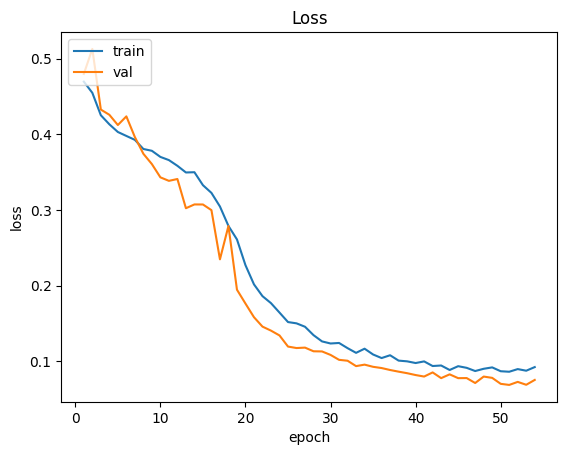

In [28]:
# draw Losses
if is_graphic:
  plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
  plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

  plt.title("Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(loc="upper left")

  plt.show()

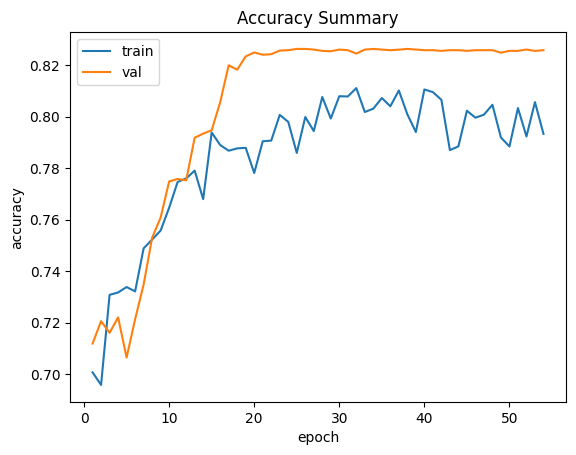

In [29]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_sum) + 1)), arr_train_acc_sum, label="train")
  plt.plot(list(range(1, len(arr_val_acc_sum) + 1)), arr_val_acc_sum, label="val")

  plt.title("Accuracy Summary")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

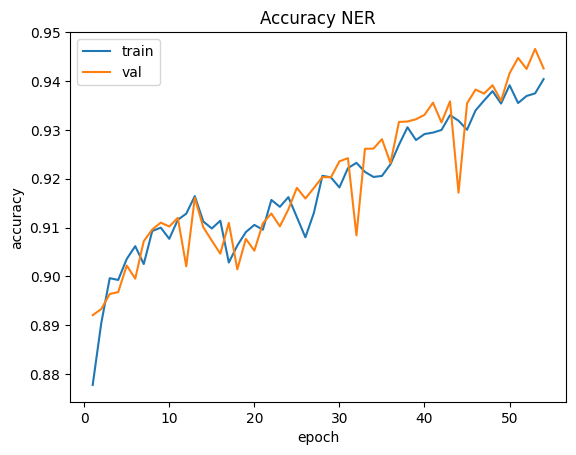

In [30]:
# draw Accuracies
if is_graphic:
  plt.plot(list(range(1, len(arr_train_acc_ner) + 1)), arr_train_acc_ner, label="train")
  plt.plot(list(range(1, len(arr_val_acc_ner) + 1)), arr_val_acc_ner, label="val")

  plt.title("Accuracy NER")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.legend(loc="upper left")

  plt.show()

## Eval model

In [31]:
model = HeterSUMGraph(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings())

In [32]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

51

In [33]:
df_test["doc_splitted"] = split_all_docs(df_test[args.doc_column_name], False)
test_set = df_test

In [34]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()

In [35]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
arr_loss_sum = []
arr_loss_ner = []
accuracy_sum = []
accuracy_ner = []

idx = 0

counter = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
  for batch in tepoch:
    tepoch.set_description("Eval model")
    data = batch["docs"].to(device)
    targets_sum = torch.tensor(batch["labels_sum"], dtype=torch.float).to(device)
    targets_ner = torch.tensor(batch["labels_ner"], dtype=torch.float).to(device)

    y_sum_pred, y_ner_pred = model(data)

    loss_sum = criterion(y_sum_pred, targets_sum)
    loss_ner = criterion(y_ner_pred, targets_ner)
    
    loss = loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

    arr_loss.append(loss.item())
    arr_loss_sum.append(loss_sum.item())
    arr_loss_ner.append(loss_ner.item())

    doc = test_set["doc_splitted"].iloc[idx]
    summaries = test_set["summaries"].iloc[idx]

    probs = np.array(y_sum_pred.tolist()) # compute_probs(y_pred)
    probs_tensor = y_sum_pred #torch.tensor(probs, dtype=torch.float).to(device)

    #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
    #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
    indices = torch.argsort(y_sum_pred, descending=True)

    y_pred_thresh = []

    txt = ""

    for i in range(min(len(doc), y_sum_pred.shape[0])):
      txt = txt + ". " + doc[indices[i]]
      y_pred_thresh.append(indices[i])
      if len(txt) >= len(summaries):
        break

    y_pred_thresh.sort()

    txt = ""

    for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
      txt = txt + ". " + doc[i]

    n = min(len(txt), len(summaries))

    while n < len(txt) and txt[n].isalnum():
      n += 1

    txt = txt[:n]

    # assert len(txt) - len(summaries) <= 20

    scores = scorer.score(summaries, txt)
    arr_rouge1.append(scores["rouge1"].recall)
    arr_rouge2.append(scores["rouge2"].recall)
    arr_rougeL.append(scores["rougeL"].recall)

    accuracy_sum.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets_sum.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
    #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))
    accuracy_ner.append(torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0])

    tepoch.set_postfix(loss=np.mean(arr_loss), loss_sum=np.mean(arr_loss_sum), loss_ner=np.mean(arr_loss_ner), rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL), accuracy_sum=np.mean(accuracy_sum), accuracy_ner=np.mean(accuracy_ner))
    idx += 1


Eval model: 100%|██████████| 100/100 [00:04<00:00, 24.23batch/s, accuracy_ner=0.881, accuracy_sum=0.695, loss=0.978, loss_ner=0.391, loss_sum=1.56, rouge1=0.276, rouge2=0.068, rougeL=0.163]


In [36]:
test_metrics = {}
test_metrics["accuracy_sum"] = np.mean(accuracy_sum)
test_metrics["accuracy_ner"] = np.mean(accuracy_ner)
test_metrics["rouge1"]   = np.mean(arr_rouge1)
test_metrics["rouge2"]   = np.mean(arr_rouge2)
test_metrics["rougeL"]   = np.mean(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
  json.dump(test_metrics, fp)

### Lead-3

In [37]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Lead-3")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(min(len(doc), 3)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        # assert len(txt) - len(summaries) <= 20

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

Lead-3: 100%|██████████| 100/100 [00:01<00:00, 55.54batch/s, rouge1=0.298, rouge2=0.0863, rougeL=0.189]


### First n char

In [38]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
accuracy = []

idx = 0
with tqdm(test_loader, unit="batch", total=len(test_loader)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("First-n-char'")
        doc = test_set["doc_splitted"].iloc[idx]

        txt = ""

        for i in range(len(doc)):
            txt = txt + doc[i]

        summaries = test_set["summaries"].iloc[idx]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        idx += 1

        tepoch.set_postfix(rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))

First-n-char': 100%|██████████| 100/100 [00:01<00:00, 58.37batch/s, rouge1=0.328, rouge2=0.0932, rougeL=0.201]


In [39]:
# Does not execute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/raoufdine/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
